In [17]:
from pathlib import Path
import os
from tqdm import tqdm
from PIL import Image
import numpy as np

In [116]:
PROCESSED_IMG_DIRECTORY_PATH = Path('/home/macosta/ttmp/primus-processed/')
PRIMUS_DIR = Path('/home/macosta/ttmp/primus/')
SAVE_CROPPED_DIR = Path('/home/macosta/ttmp/primus-cropped/')
SAVE_TXT_DIR = Path('/home/macosta/ttmp/primus-cropped-txt/')

In [21]:
HEIGHT = 95

In [56]:
def get_png_paths():
    png_paths = []
    for package in os.listdir(PRIMUS_DIR):
        package_path = PRIMUS_DIR / package
        for incipit_dir in os.listdir(package_path):
            incipit_dir_path = package_path / incipit_dir
            incipit_files = os.listdir(incipit_dir_path)
            png_files = [f for f in incipit_files if f[-4:] == '.png' and f[0] != '.']
            if not png_files:
                continue
            png_file = incipit_dir_path / png_files[0]
            png_paths.append(str(png_file))
    return png_paths

  0%|                                                 | 0/87678 [00:00<?, ?it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/211005835-1_1_2.png


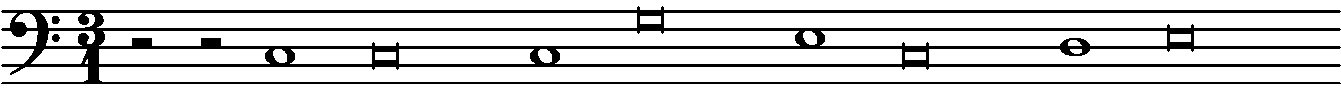

  0%|                                     | 110/87678 [00:00<01:20, 1090.85it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/211004232-1_1_2.png


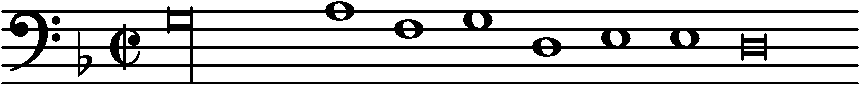

  1%|▏                                    | 528/87678 [00:00<01:04, 1354.09it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/000107608-1_2_2.png


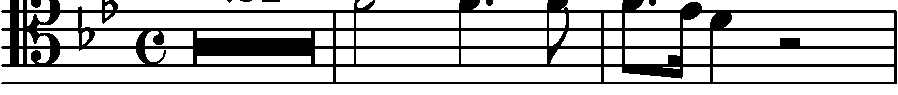

  1%|▎                                    | 808/87678 [00:00<01:02, 1381.63it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/000127515-1_1_1.png


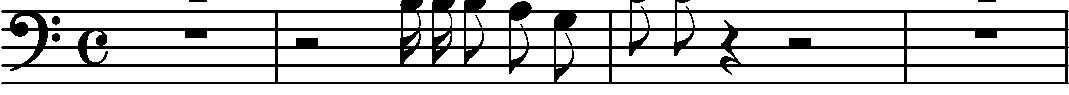

  1%|▍                                    | 947/87678 [00:00<01:03, 1370.65it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/110003649-1_1_1.png


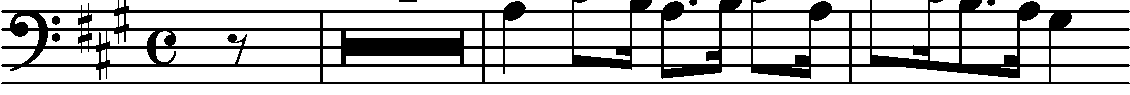

  1%|▍                                   | 1085/87678 [00:00<01:03, 1362.31it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/000130957-1_1_2.png


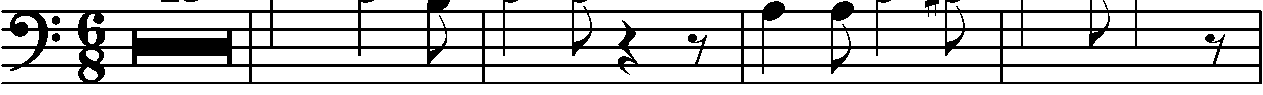

  1%|▌                                   | 1224/87678 [00:00<01:03, 1370.13it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/225003650-1_1_1.png


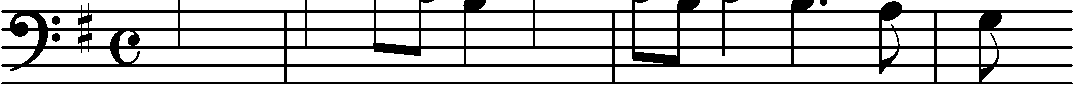

  2%|▌                                   | 1362/87678 [00:01<01:03, 1365.91it/s]

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/225001072-1_13_1.png


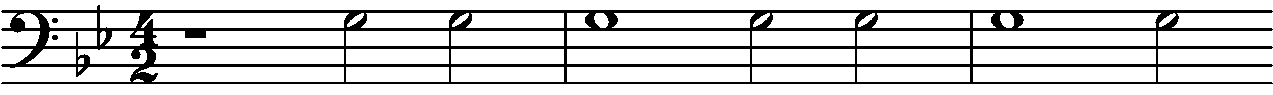

Assertion error: There are 14 near-max-value rows
/home/macosta/ttmp/primus-processed/000101842-1_1_1.png


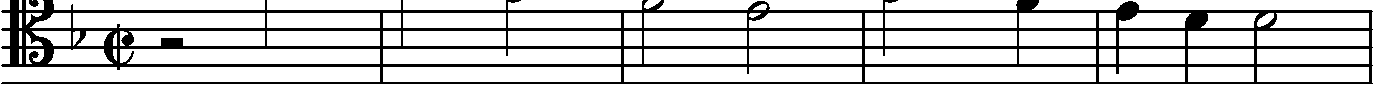

  2%|▊                                    | 2018/87678 [00:05<03:45, 379.72it/s]


KeyboardInterrupt: 

In [45]:
def check_stafflines_in_original_db():
    for txt_path in tqdm(os.listdir(PROCESSED_IMG_DIRECTORY_PATH)):
        full_path = PROCESSED_IMG_DIRECTORY_PATH / txt_path
        if not os.path.isfile(full_path):
            continue
        img = Image.open(full_path)
        img_np = (1 - np.array(img))
        row_vals = np.sum(img_np, axis=1)
        try:
            assert row_vals.shape[0] == HEIGHT, f"Image height is not {HEIGHT}"
            index_weight_pairs = list(zip(np.arange(len(row_vals)), row_vals))
            max_val = max(row_vals)
            max_rows = [x for x in index_weight_pairs if x[1] == max_val]
            stafflines = [x for x in index_weight_pairs if x[1] >= max_val - 2]
            assert len(max_rows) == 5, f"There are not {len(max_rows)} max-value rows"
            assert len(stafflines) == 15, f"There are {len(stafflines)} near-max-value rows"
        except AssertionError as e:
            print(f"Assertion error: {e}")
            print(full_path)
            img.show()

In [57]:
# png_paths = get_png_paths()

In [114]:
def calculate_index_weight_pairs(img_np):
    row_vals = np.sum(img_np, axis=1)
    return row_vals, list(zip(np.arange(len(row_vals)), row_vals))

def crop_img_np(img_np, top_staffline_center, bottom_staffline_center, buffer_px):
    desired_height = 18 * 4 + 3 + buffer_px * 2
    top, bottom = top_staffline_center - 1 - buffer_px, bottom_staffline_center + 1 + buffer_px
    # Pad with zeros if top goes above image
    if top < 0:
        img_np = np.vstack((np.zeros((-top, img_np.shape[1])), img_np))
        bottom -= top
        top = 0
    if bottom >= img_np.shape[0]:
        img_np = np.vstack((img_np, np.zeros((bottom - img_np.shape[0] + 1, img_np.shape[1]))))
    cropped = img_np[top : bottom + 1, :].astype(np.uint8)
    assert cropped.shape[0] == desired_height, f"Assertion failed: cropped image has height {cropped.shape[0]}, not {desired_height}"
    return cropped

def save_safe_crops(savedir, buffer_px=50):
    savedir.mkdir(exist_ok=True)
    for png_path in tqdm(png_paths):
        img_np = np.array(Image.open(png_path))
        row_vals, index_weight_pairs = calculate_index_weight_pairs(img_np)
        max_val = max(row_vals)
        max_rows = [x[0] for x in index_weight_pairs if x[1] == max_val]
        assert len(max_rows) == 5, f"Assertion failed: {len(max_rows)} max rows found"
        if max_rows[-1] == len(img_np) - 1:
            img_np = np.vstack((img_np, [img_np[-2]]))
        cropped = crop_img_np(img_np, max_rows[0], max_rows[-1], buffer_px)
        row_vals, index_weight_pairs = calculate_index_weight_pairs(cropped)
        max_rows = [x[0] for x in index_weight_pairs if x[1] == max_val]
        near_max_rows = [x[0] for x in index_weight_pairs if x[1] >= max_val - 2 and x[1] < max_val]
        assert len(near_max_rows) == 10, f"Assertion failed: {len(near_max_rows)} near max rows found"
        for i in range(5):
            assert near_max_rows[i*2] + 1 == max_rows[i], f"Assertion failed: {i}th staff line doesn't match {i*2}th near max row"
            assert near_max_rows[i*2+1] - 1 == max_rows[i], f"Assertion failed: {i}th staff line doesn't match {i*2+1}th near max row"
            if i > 0:
                assert max_rows[i] - max_rows[i-1] == 18, f"Assertion failed: found {max_rows[i] - max_rows[i-1]} pixels between stafflines {i-1} and {i}"
        assert max_rows[0] == buffer_px + 1, f"Assertion failed: expected first staff line to be at {buffer_px+1}, found it at {max_rows[0]} instead"
        savename = savedir / Path(png_path).name
        img_cropped = Image.fromarray((1 - cropped) * 255, mode='L').convert('1')
        img_cropped.save(savename)

In [115]:
# save_safe_crops(SAVE_CROPPED_DIR)

100%|████████████████████████████████████| 87678/87678 [06:29<00:00, 225.08it/s]


In [125]:
def image_to_txt_columnwise(from_dir, to_dir):
    to_dir.mkdir(exist_ok=True)
    for img_filename in tqdm(os.listdir(from_dir)):
        img_full_path = from_dir / img_filename
        savepath = to_dir / f"{Path(img_filename).name[:-4]}.txt"
        img_np = 1 - np.array(Image.open(img_full_path), dtype=np.uint8)
        full_text = ""
        for i in range(img_np.shape[1]):
            column = img_np[:,i]
            column_txt = "".join([str(digit) for digit in column])
            full_text += f"{column_txt} "
        full_text = full_text.strip()
        with open(savepath, "w") as f:
            f.write(full_text)

In [126]:
image_to_txt_columnwise(SAVE_CROPPED_DIR, SAVE_TXT_DIR)

 44%|██████████████▌                  | 38552/87678 [1:06:45<1:25:04,  9.62it/s]


KeyboardInterrupt: 

In [131]:
for txt_filename in tqdm(os.listdir(SAVE_TXT_DIR)):
    txt_full_path = SAVE_TXT_DIR / txt_filename
    if not os.path.isfile(txt_full_path):
        continue
    with open(txt_full_path, "r") as f:
        text = f.read()
    text = text.split()
    for col in text:
        assert(len(col) == 18 * 4 + 3 + 50 * 2)

100%|███████████████████████████████████| 87679/87679 [00:41<00:00, 2095.67it/s]
